In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from k_means import run_kmeans

### Patrones horarios


🔍 Entrenando K-Means con K = 3 clusters...


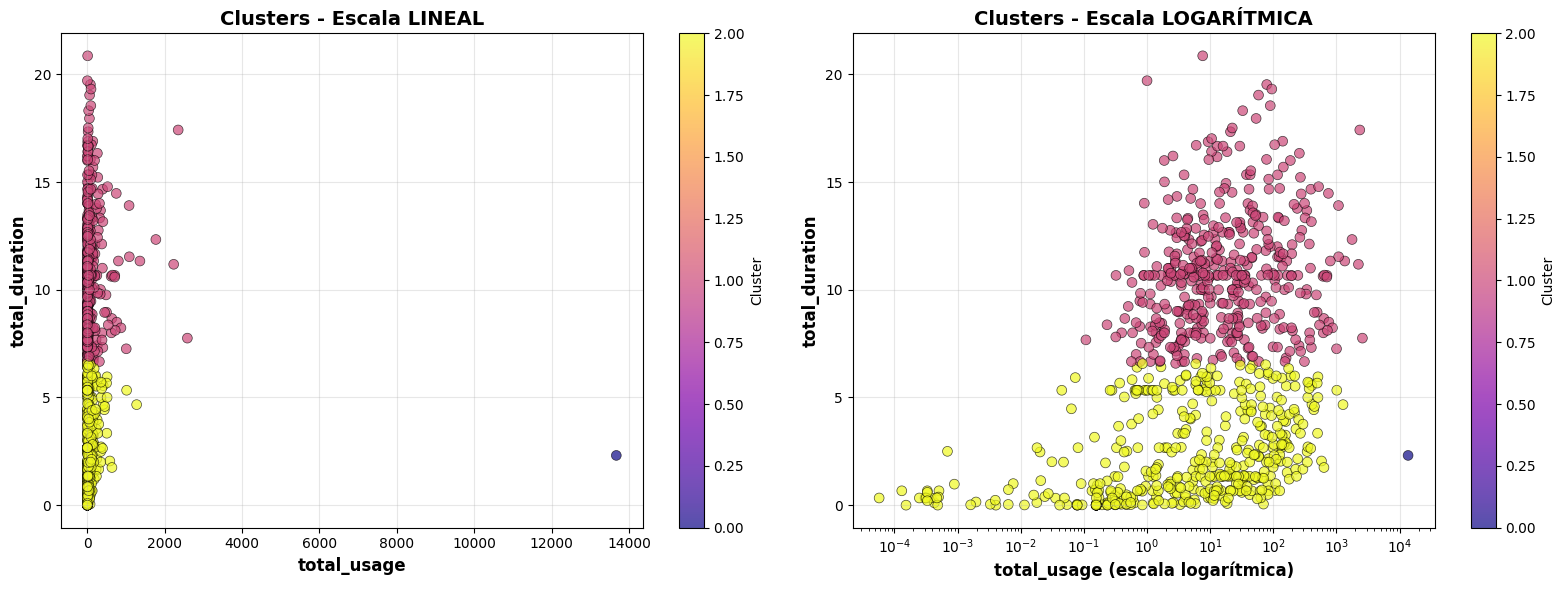

Resumen del día (00–08):
                 total_usage  total_duration  user_count  usage_percent
perfil_consumo                                                         
Alto            1.433565e+10        2.309444           1          16.91
Bajo            2.497508e+10     1033.895000         451          29.45
Normal          4.548735e+10     4649.105278         430          53.64


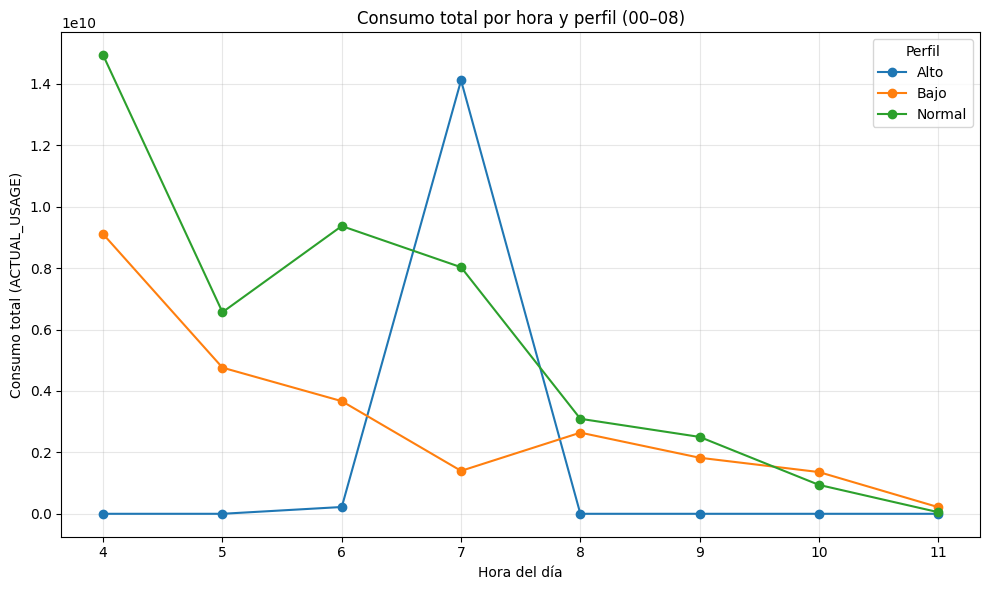

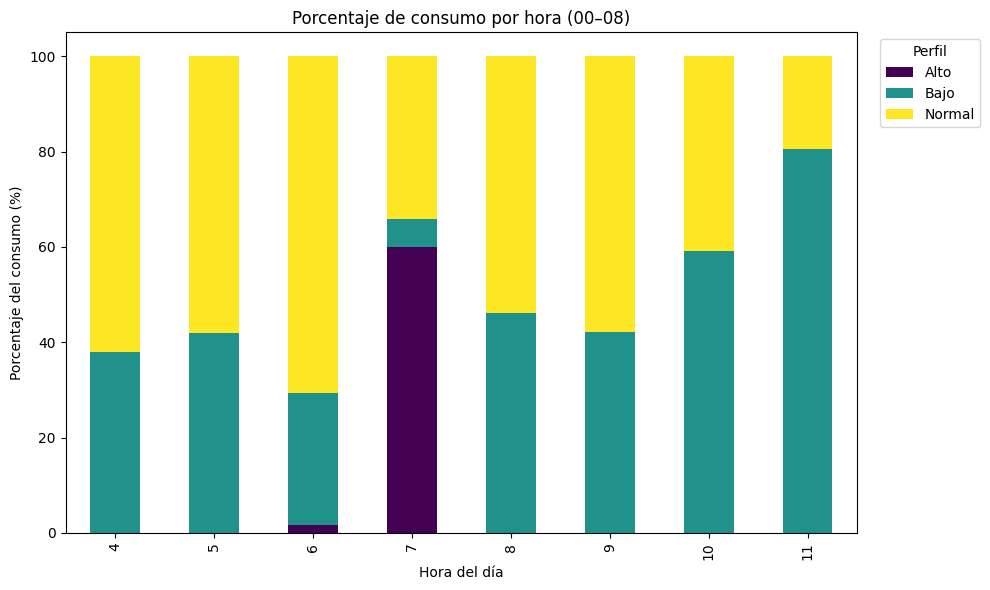

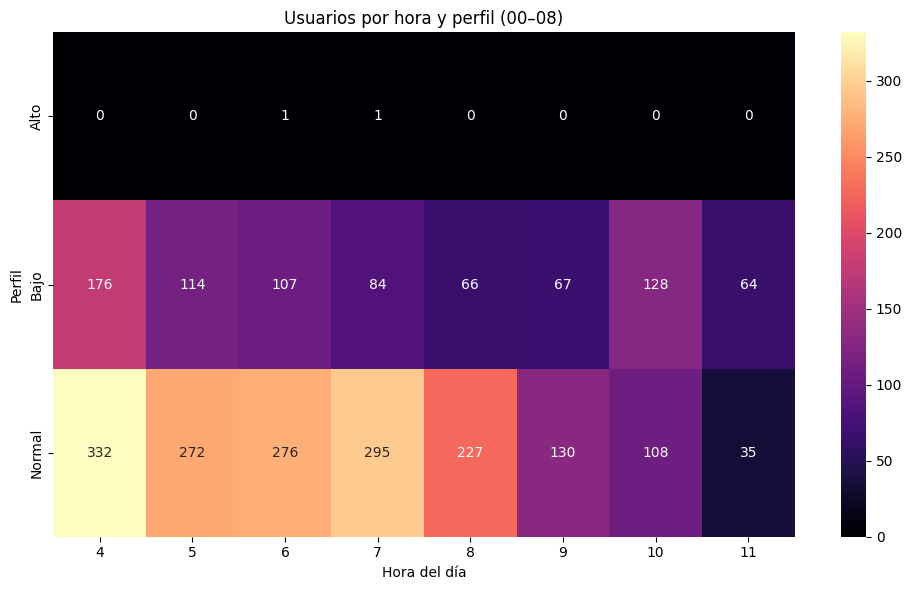

In [2]:
# 1) Cargar dataset
df = pd.read_csv("../data/synthetic_data/datos_a_completar.csv")

# 2) Convertir fechas a datetime
df['START_DATE'] = pd.to_datetime(df['START_DATE'])
df['END_DATE'] = pd.to_datetime(df['END_DATE'])
df['ACTUAL_USAGE_MB'] = df['ACTUAL_USAGE'] / (1024 ** 2)

# 3) Crear columna de duración en horas
df['DURATION_HOURS'] = (df['END_DATE'] - df['START_DATE']).dt.total_seconds() / 3600

# 4) Cargar outliers detectados por DBSCAN
# outliers = pd.read_csv("../outliers-analysis/outliers.csv")

# # 5) Quitar outliers del dataset
# df_no_outliers = df[~df.index.isin(outliers.index)].copy()
# df_1 = df_no_outliers
df_1 = df

# 6) AGRUPAR POR USUARIO (OBJ_ID) antes de clustering  # <-- agregado
usuarios = df_1.groupby('OBJ_ID').agg(
    total_usage=('ACTUAL_USAGE_MB','sum'),
    total_duration=('DURATION_HOURS','sum'),
    num_sessions=('ACTUAL_USAGE_MB','count')
).reset_index()

# 7) Ejecutar tu método run_kmeans con las variables agregadas por usuario  # <-- cambiado
result = run_kmeans(usuarios, features=['total_usage','total_duration'])

# 8) Mapear clusters a perfiles (Bajo, Normal, Alto)
cluster_stats = result.groupby('cluster_kmeans')['total_usage'].mean().sort_values()  # <-- cambiado (usa total_usage)
orden = cluster_stats.index.tolist()
nombres = {orden[0]:'Bajo', orden[1]:'Normal', orden[2]:'Alto'}
result['perfil_consumo'] = result['cluster_kmeans'].map(nombres)

# 9) VOLVER A UNIR perfiles al dataset original para análisis horario  # <-- agregado
df_1 = df_1.merge(result[['OBJ_ID','perfil_consumo']], on='OBJ_ID', how='left')

# 10) Extraer hora del START_DATE
df_1['hour'] = df_1['START_DATE'].dt.hour

# 11) Agregaciones por hora y perfil (usuarios únicos en vez de filas)  # <-- cambiado
agg = df_1.groupby(['perfil_consumo','hour']).agg(
    total_usage=('ACTUAL_USAGE','sum'),
    total_duration=('DURATION_HOURS','sum'),
    user_count=('OBJ_ID','nunique')   # <-- cambiado: cuenta usuarios únicos
).reset_index()

# 12) Pivot para tablas por hora
usage_hourly = agg.pivot(index='hour', columns='perfil_consumo', values='total_usage').fillna(0)
duration_hourly = agg.pivot(index='hour', columns='perfil_consumo', values='total_duration').fillna(0)
count_hourly = agg.pivot(index='hour', columns='perfil_consumo', values='user_count').fillna(0)
usage_hourly_pct = usage_hourly.div(usage_hourly.sum(axis=1).replace(0,np.nan), axis=0) * 100

# 13) Resumen total del día (usuarios únicos)  # <-- cambiado
day_summary = df_1.groupby('perfil_consumo').agg(
    total_usage=('ACTUAL_USAGE','sum'),
    total_duration=('DURATION_HOURS','sum'),
    user_count=('OBJ_ID','nunique')   # <-- cambiado
)
total_day_usage = day_summary['total_usage'].sum()
day_summary['usage_percent'] = (day_summary['total_usage']/total_day_usage*100).round(2)

print("Resumen del día (00–08):")
print(day_summary)

# 14) Visualizaciones
usage_hourly.plot(kind='line', marker='o', figsize=(10,6))
plt.title("Consumo total por hora y perfil (00–08)")
plt.xlabel("Hora del día")
plt.ylabel("Consumo total (ACTUAL_USAGE)")
plt.legend(title="Perfil")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("results/consumo_por_hora_lineas.png", dpi=300)
plt.show()
plt.close()

usage_hourly_pct.plot(kind='bar', stacked=True, figsize=(10,6), colormap='viridis')
plt.title("Porcentaje de consumo por hora (00–08)")
plt.xlabel("Hora del día")
plt.ylabel("Porcentaje del consumo (%)")
plt.legend(title="Perfil", bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.savefig("results/consumo_por_hora_porcentaje.png", dpi=300)
plt.show()
plt.close()

plt.figure(figsize=(10,6))
sns.heatmap(count_hourly.T, annot=True, fmt=".0f", cmap="magma")
plt.title("Usuarios por hora y perfil (00–08)")
plt.xlabel("Hora del día")
plt.ylabel("Perfil")
plt.tight_layout()
plt.savefig("results/usuarios_por_hora_heatmap.png", dpi=300)
plt.show()
plt.close()

# 15) Guardar reporte interpretado
with open("results/patrones_horarios.txt","w",encoding="utf-8") as f:
    f.write("Resumen del día (00–08):\n")
    for perfil,row in day_summary.iterrows():
        f.write(f"- {perfil}: usuarios={row['user_count']}, consumo_total={row['total_usage']:.2f}, "
                f"duracion_total_h={row['total_duration']:.2f}, participacion_consumo={row['usage_percent']:.2f}%\n")
    f.write("\nHallazgos por hora:\n")
    for h in sorted(usage_hourly.index):
        total_h = usage_hourly.loc[h].sum()
        f.write(f"Hora {h:02d}: consumo_total={total_h:.2f}\n")
        top_perfil = usage_hourly.loc[h].idxmax()
        top_val = usage_hourly.loc[h].max()
        f.write(f"  - Perfil dominante: {top_perfil} ({top_val:.2f})\n")
        for perfil in usage_hourly.columns:
            pct = usage_hourly_pct.loc[h, perfil]
            if not np.isnan(pct):
                f.write(f"  - {perfil}: {pct:.2f}% del consumo\n")
        counts = count_hourly.loc[h]
        f.write("  - Usuarios por perfil: " + ", ".join([f"{p}: {int(c)}" for p,c in counts.items()]) + "\n\n")


### Consumo vs Duracion

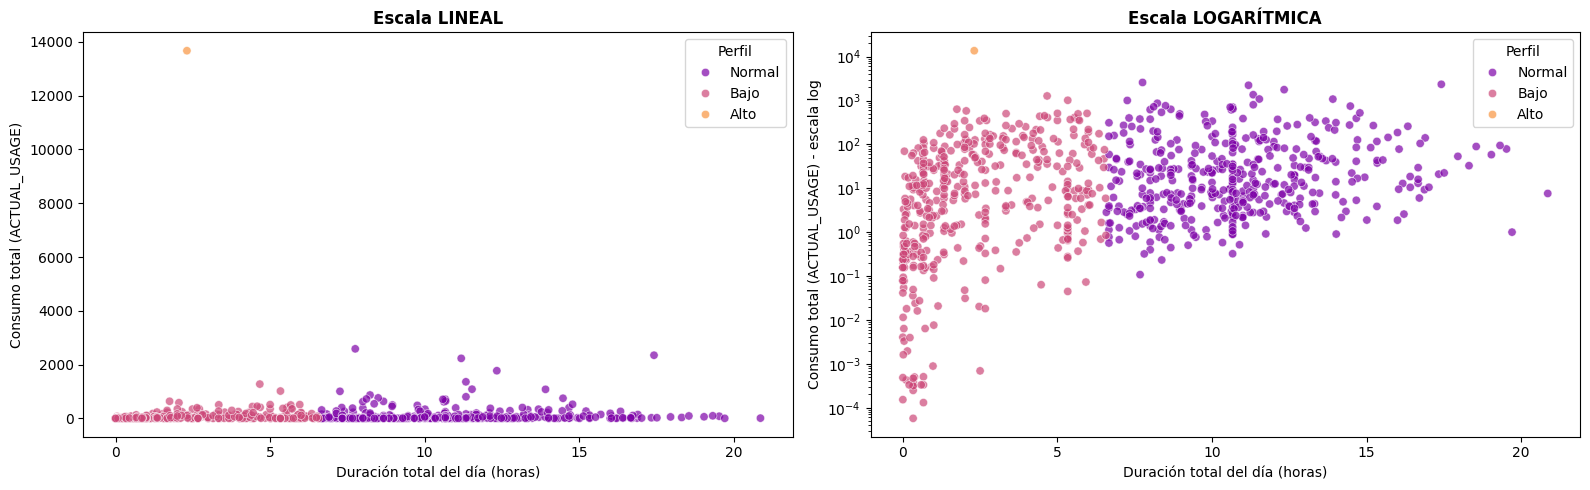

C:\Users\Joel\AppData\Local\Temp\ipykernel_2176\4195518299.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result, x='perfil_consumo', y='total_duration', palette='plasma')


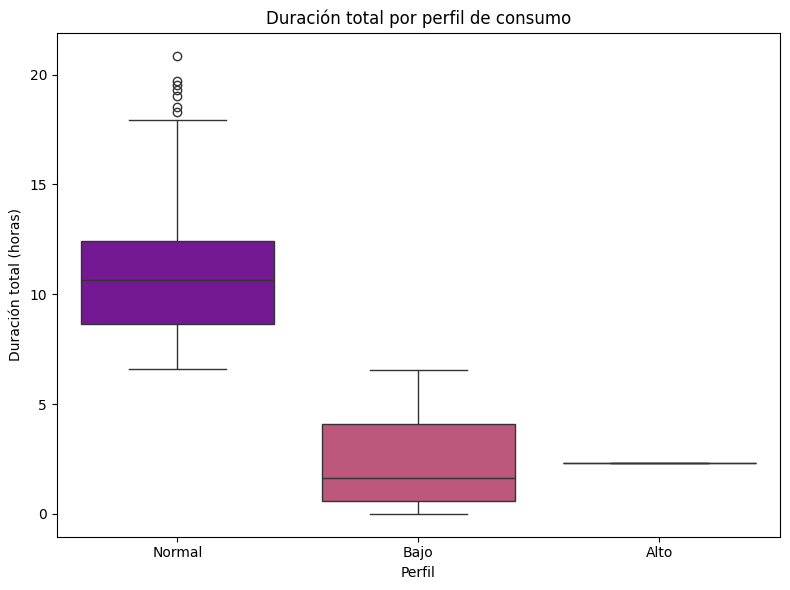

In [3]:
# Scatter plot consumo vs duración: LINEAL vs LOGARÍTMICA
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Scatter LINEAL
sns.scatterplot(
    data=result,
    x='total_duration',
    y='total_usage',
    hue='perfil_consumo',
    palette='plasma',
    alpha=0.7,
    ax=axes[0]
)
axes[0].set_title("Escala LINEAL", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Duración total del día (horas)")
axes[0].set_ylabel("Consumo total (ACTUAL_USAGE)")
axes[0].legend(title="Perfil", loc='upper right')

# Scatter LOGARÍTMICA
sns.scatterplot(
    data=result,
    x='total_duration',
    y='total_usage',
    hue='perfil_consumo',
    palette='plasma',
    alpha=0.7,
    ax=axes[1]
)
axes[1].set_yscale('log')
axes[1].set_title("Escala LOGARÍTMICA", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Duración total del día (horas)")
axes[1].set_ylabel("Consumo total (ACTUAL_USAGE) - escala log")
axes[1].legend(title="Perfil", loc='upper right')

plt.tight_layout()
plt.savefig("results/distribucion_consumo_duracion.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Boxplot para comparar duración por perfil
plt.figure(figsize=(8,6))
sns.boxplot(data=result, x='perfil_consumo', y='total_duration', palette='plasma')
plt.title("Duración total por perfil de consumo")
plt.xlabel("Perfil")
plt.ylabel("Duración total (horas)")
plt.tight_layout()
plt.savefig("results/boxplot_duracion_perfil.png", dpi=300)
plt.show()
plt.close()


### Patron de outliers

In [4]:
# 1) Cargar outliers
outliers = pd.read_csv("../outliers-analysis/results/datos/DATOS_outliers.csv")

# 2) Asegurar que las fechas estén en datetime y recalcular duración si es posible
if 'START_DATE' in outliers.columns and 'END_DATE' in outliers.columns:
    outliers['START_DATE'] = pd.to_datetime(outliers['START_DATE'], errors='coerce')
    outliers['END_DATE'] = pd.to_datetime(outliers['END_DATE'], errors='coerce')

    if 'DURATION_HOURS' not in outliers.columns:
        outliers['DURATION_HOURS'] = (outliers['END_DATE'] - outliers['START_DATE']).dt.total_seconds() / 3600

# 3) Si aún no existe DURATION_HOURS, crearla como 0 para evitar KeyError  # <-- agregado
if 'DURATION_HOURS' not in outliers.columns:
    outliers['DURATION_HOURS'] = 0.0

# 4) Agrupar outliers por usuario (usa la columna correcta de ID)  # <-- cambiado
# Verifica si tu CSV usa 'ID' en vez de 'OBJ_ID'
id_col = 'OBJ_ID' if 'OBJ_ID' in outliers.columns else 'ID'

outliers_usuarios = outliers.groupby(id_col).agg(
    total_usage=('ACTUAL_USAGE','sum'),
    total_duration=('DURATION_HOURS','sum'),
    num_sessions=('ACTUAL_USAGE','count')
).reset_index()


### Trafico por cluster

Resumen de participación en el tráfico total:
                 total_usage  total_duration  user_count  usage_percent  \
perfil_consumo                                                            
Alto            13671.539576        2.309444           1          16.91   
Bajo            23818.095445     1033.895000         451          29.45   
Normal          43380.117234     4649.105278         430          53.64   

                usage_per_user  
perfil_consumo                  
Alto                  13671.54  
Bajo                     52.81  
Normal                  100.88  


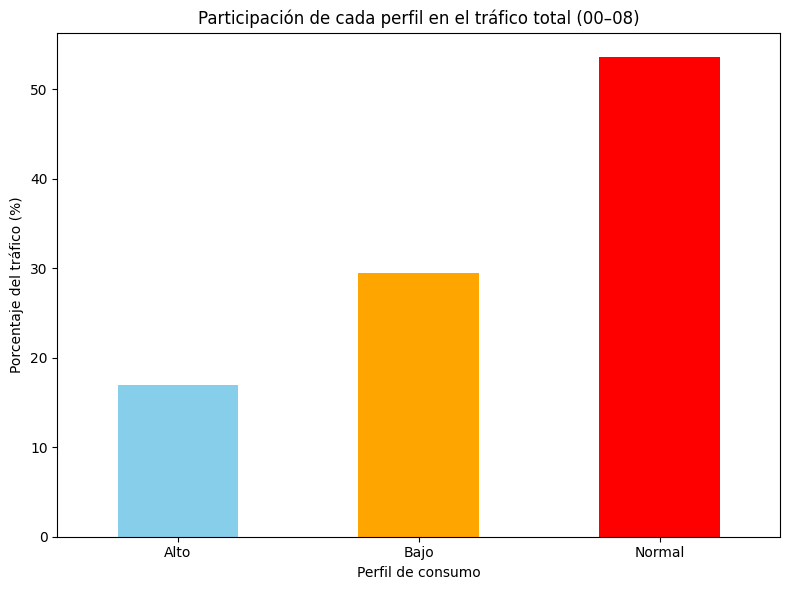

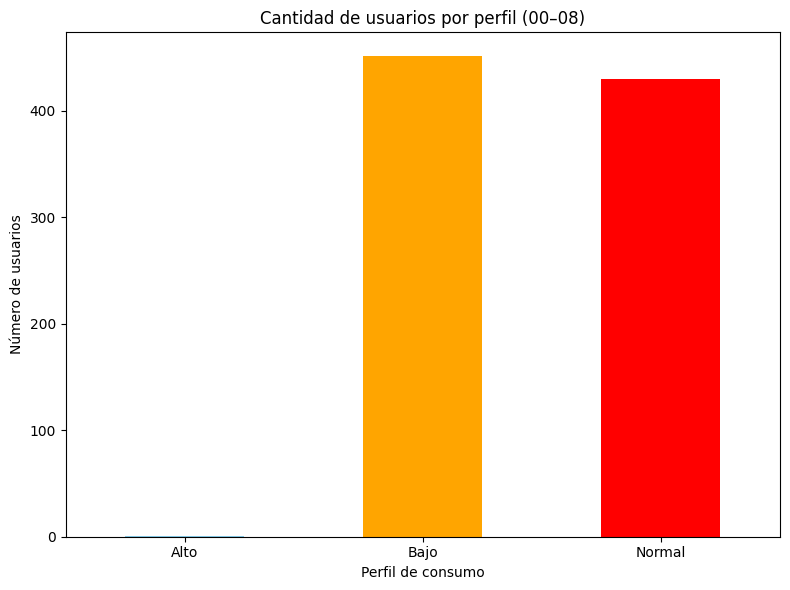

In [5]:
# 1) Resumen por perfil (usa métricas agregadas por usuario)  # <-- cambiado
cluster_summary = result.groupby('perfil_consumo').agg(
    total_usage=('total_usage','sum'),        # <-- cambiado
    total_duration=('total_duration','sum'),  # <-- cambiado
    user_count=('OBJ_ID','nunique')               # <-- cambiado: cuenta usuarios únicos
)

# 2) Porcentaje de tráfico total por cluster
total_usage = cluster_summary['total_usage'].sum()
cluster_summary['usage_percent'] = (cluster_summary['total_usage'] / total_usage * 100).round(2)

# 3) Consumo promedio por usuario en cada cluster
cluster_summary['usage_per_user'] = (cluster_summary['total_usage'] / cluster_summary['user_count']).round(2)

print("Resumen de participación en el tráfico total:")
print(cluster_summary)

# 4) Visualización: participación en el tráfico total
plt.figure(figsize=(8,6))
cluster_summary['usage_percent'].plot(kind='bar', color=['skyblue','orange','red'])
plt.title("Participación de cada perfil en el tráfico total (00–08)")
plt.xlabel("Perfil de consumo")
plt.ylabel("Porcentaje del tráfico (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("results/participacion_clusters.png", dpi=300)
plt.show()
plt.close()

# 5) Visualización: cantidad de usuarios por perfil
plt.figure(figsize=(8,6))
cluster_summary['user_count'].plot(kind='bar', color=['skyblue','orange','red'])
plt.title("Cantidad de usuarios por perfil (00–08)")
plt.xlabel("Perfil de consumo")
plt.ylabel("Número de usuarios")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("results/usuarios_por_perfil.png", dpi=300)
plt.show()
plt.close()


### Clustering con reduccion de dimensionalidad

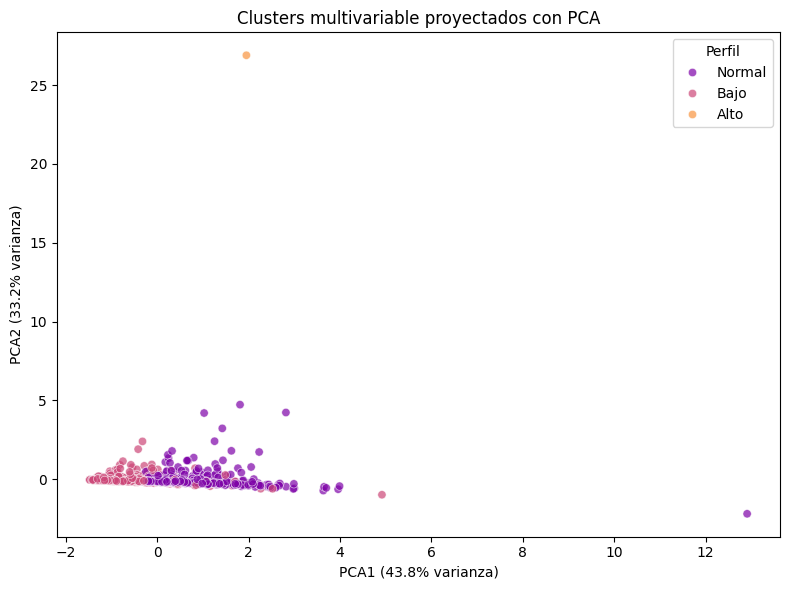

Contribución de cada variable a los componentes principales:
      total_usage  total_duration  num_sessions
PCA1     0.111495        0.704696      0.700694
PCA2     0.992445       -0.042627     -0.115049


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1) Seleccionar variables adicionales (usa métricas agregadas por usuario)  # <-- cambiado
features = ['total_usage','total_duration','num_sessions']   # <-- cambiado
# Si tienes más columnas relevantes, añádelas aquí, por ejemplo:
# features = ['total_usage','total_duration','num_sessions','VARIABILIDAD_CONSUMO']

X = result[features]   # <-- cambiado

# 2) Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3) PCA a 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 4) Guardar resultados en el DataFrame
result['PCA1'] = X_pca[:,0]
result['PCA2'] = X_pca[:,1]

# 5) Visualización PCA coloreada por perfil
plt.figure(figsize=(8,6))
sns.scatterplot(data=result, x='PCA1', y='PCA2', hue='perfil_consumo', palette='plasma', alpha=0.7)
plt.title("Clusters multivariable proyectados con PCA")
plt.xlabel(f"PCA1 ({pca.explained_variance_ratio_[0]*100:.1f}% varianza)")
plt.ylabel(f"PCA2 ({pca.explained_variance_ratio_[1]*100:.1f}% varianza)")
plt.legend(title="Perfil")
plt.tight_layout()
plt.savefig("results/pca_clusters.png", dpi=300)
plt.show()
plt.close()

# 6) Importancia de cada variable en los componentes principales
pca_components = pd.DataFrame(pca.components_, columns=features, index=['PCA1','PCA2'])
print("Contribución de cada variable a los componentes principales:")
print(pca_components)


### Preferencia de bajos consumidores de datos por otros servicios

A continuació se analizan las preferencias de los bajos consumidores de datos móviles por sservicios de voz y SMS

#### Preferencia por SMS

Se plantea la hipótesis de que la gran parte de bajos consumidores de datos móviles prefieren el uso de mensajes, es decir, que 60% o más de los consumidores bajos de datos se encuentran entre los consumidores normales o altos de SMS con un 95% se seguridad.

In [7]:
# 1) Cargar muestra.xlsx (datos con TODOS los servicios)
df_completo = pd.read_excel("../data/muestra.xlsx")

# 2) Convertir fechas
df_completo['START_DATE'] = pd.to_datetime(df_completo['START_DATE'])
df_completo['END_DATE'] = pd.to_datetime(df_completo['END_DATE'])
df_completo['DURATION_HOURS'] = (df_completo['END_DATE'] - df_completo['START_DATE']).dt.total_seconds() / 3600

# 3) Ver qué SERVICE_CATEGORY tenemos
print("SERVICE_CATEGORY valores únicos:")
print(df_completo['SERVICE_CATEGORY'].value_counts())
print()

# 4) Datos para DATOS (SERVICE_CATEGORY=5) 
print("PASO 1: Analizando DATOS (SERVICE_CATEGORY=5)")
df_datos = df_completo[df_completo['SERVICE_CATEGORY'] == 5].copy()
print(f"Registros de DATOS: {len(df_datos)}")

usuarios_datos = df_datos.groupby('OWNER_CUST_ID').agg(
    total_usage=('ACTUAL_USAGE', 'sum')
).reset_index()
usuarios_datos.columns = ['OWNER_CUST_ID', 'uso_datos']
print(f"Usuarios únicos en DATOS: {len(usuarios_datos)}")
print()

# 5) Datos para SMS (SERVICE_CATEGORY=2)
print("PASO 2: Analizando SMS (SERVICE_CATEGORY=2)")
df_sms = df_completo[df_completo['SERVICE_CATEGORY'] == 2].copy()
print(f"Registros de SMS: {len(df_sms)}")

usuarios_sms = df_sms.groupby('OWNER_CUST_ID').agg(
    total_usage=('ACTUAL_USAGE', 'sum')
).reset_index()
usuarios_sms.columns = ['OWNER_CUST_ID', 'uso_sms']
print(f"Usuarios únicos en SMS: {len(usuarios_sms)}")
print()


SERVICE_CATEGORY valores únicos:
SERVICE_CATEGORY
5     7875
2     1551
15     418
1      156
Name: count, dtype: int64

PASO 1: Analizando DATOS (SERVICE_CATEGORY=5)
Registros de DATOS: 7875
Usuarios únicos en DATOS: 881

PASO 2: Analizando SMS (SERVICE_CATEGORY=2)
Registros de SMS: 1551
Usuarios únicos en SMS: 324



In [8]:
# 6) K-MEANS CLUSTERING PARA DATOS usando run_kmeans
print("PASO 3: Clustering en DATOS (K-means)")

# Preparar dataframe con uso de datos por usuario
usuarios_datos_cluster = usuarios_datos[['OWNER_CUST_ID', 'uso_datos']].copy()
usuarios_datos_cluster = usuarios_datos_cluster.rename(columns={'uso_datos': 'total_usage'})

# Aplicar run_kmeans
result_datos = run_kmeans(usuarios_datos_cluster, features=['total_usage'])

# Mapear clusters a perfiles (Bajo, Normal, Alto)
cluster_medias_datos = result_datos.groupby('cluster_kmeans')['total_usage'].mean().sort_values()
orden_datos = cluster_medias_datos.index.tolist()
mapeo_datos = {orden_datos[0]: 'Bajo', orden_datos[1]: 'Normal', orden_datos[2]: 'Alto'}
result_datos['perfil_datos'] = result_datos['cluster_kmeans'].map(mapeo_datos)

# Volver a unir con OWNER_CUST_ID
result_datos_reset = result_datos.reset_index()
usuarios_datos = result_datos_reset[['OWNER_CUST_ID', 'total_usage', 'cluster_kmeans', 'perfil_datos']].copy()
usuarios_datos.columns = ['OWNER_CUST_ID', 'uso_datos', 'cluster_datos', 'perfil_datos']

print("\nPerfiles en DATOS:")
print(usuarios_datos.groupby('perfil_datos')['uso_datos'].describe())
print()

# 7) K-MEANS CLUSTERING PARA SMS usando run_kmeans
print("PASO 4: Clustering en SMS (K-means)")

# Preparar dataframe con uso de SMS por usuario
usuarios_sms_cluster = usuarios_sms[['OWNER_CUST_ID', 'uso_sms']].copy()
usuarios_sms_cluster = usuarios_sms_cluster.rename(columns={'uso_sms': 'total_usage'})

# Aplicar run_kmeans
result_sms = run_kmeans(usuarios_sms_cluster, features=['total_usage'])

# Mapear clusters a perfiles (Bajo, Normal, Alto)
cluster_medias_sms = result_sms.groupby('cluster_kmeans')['total_usage'].mean().sort_values()
orden_sms = cluster_medias_sms.index.tolist()
mapeo_sms = {orden_sms[0]: 'Bajo', orden_sms[1]: 'Normal', orden_sms[2]: 'Alto'}
result_sms['perfil_sms'] = result_sms['cluster_kmeans'].map(mapeo_sms)

# Volver a unir con OWNER_CUST_ID
result_sms_reset = result_sms.reset_index()
usuarios_sms = result_sms_reset[['OWNER_CUST_ID', 'total_usage', 'cluster_kmeans', 'perfil_sms']].copy()
usuarios_sms.columns = ['OWNER_CUST_ID', 'uso_sms', 'cluster_sms', 'perfil_sms']

print("\nPerfiles en SMS:")
print(usuarios_sms.groupby('perfil_sms')['uso_sms'].describe())
print()


PASO 3: Clustering en DATOS (K-means)

🔍 Entrenando K-Means con K = 3 clusters...
⚠️ Se necesitan al menos 2 variables para visualizar en 2D

Perfiles en DATOS:
              count          mean           std           min           25%  \
perfil_datos                                                                  
Alto            1.0  1.433565e+10           NaN  1.433565e+10  1.433565e+10   
Bajo          857.0  5.188206e+07  9.668568e+07  6.000000e+01  1.801504e+06   
Normal         23.0  1.130413e+09  6.244979e+08  6.098361e+08  7.085935e+08   

                       50%           75%           max  
perfil_datos                                            
Alto          1.433565e+10  1.433565e+10  1.433565e+10  
Bajo          1.004779e+07  4.934920e+07  5.660889e+08  
Normal        8.408796e+08  1.236168e+09  2.710554e+09  

PASO 4: Clustering en SMS (K-means)

🔍 Entrenando K-Means con K = 3 clusters...
⚠️ Se necesitan al menos 2 variables para visualizar en 2D

Perfiles en SMS:


In [9]:
# 8) TEST DE HIPÓTESIS CON BOOTSTRAP: ¿Bajos consumidores de datos prefieren SMS?
# Hipótesis: H0: p ≤ 0.60 
# Hipótesis alternativa H1: p > 0.60 (cola derecha)

print("="*80)
print("TEST DE HIPÓTESIS CON BOOTSTRAP: PREFERENCIA DE SMS")
print("="*80)
print()

# Cruzar información: usuarios bajos en datos vs su clasificación en SMS
cruce = usuarios_datos.merge(usuarios_sms, on='OWNER_CUST_ID', how='inner')

# Identificar bajos consumidores de datos
bajos_datos = cruce[cruce['perfil_datos'] == 'Bajo'].copy()

print(f"Total de bajos consumidores de DATOS: {len(bajos_datos)}")
print(f"Distribución en bajos consumidores de DATOS:")
print(bajos_datos['perfil_sms'].value_counts())
print()

# De los bajos en datos, contar cuántos son ALTOS o NORMALES en SMS
bajos_datos['es_alto_o_normal_sms'] = bajos_datos['perfil_sms'].isin(['Alto', 'Normal'])
count_altos_normales = bajos_datos['es_alto_o_normal_sms'].sum()
count_bajos_sms = len(bajos_datos) - count_altos_normales
proporcion_observada = count_altos_normales / len(bajos_datos) if len(bajos_datos) > 0 else 0

print(f"Bajos en DATOS que son ALTOS o NORMALES en SMS: {count_altos_normales}")
print(f"Bajos en DATOS que son BAJOS en SMS: {count_bajos_sms}")
print(f"Total: {len(bajos_datos)}")
print(f"Proporción observada: {proporcion_observada:.4f} ({proporcion_observada*100:.2f}%)")
print()

# ============================================================================
# BOOTSTRAP: INTERVALO DE CONFIANZA
# ============================================================================
print("="*80)
print("PASO 1: INTERVALO DE CONFIANZA CON BOOTSTRAP")
print("="*80)
print()

print("METODOLOGÍA:")
print("  • Remuestrea 10,000 veces CON REEMPLAZO de los datos observados")
print("  • En cada remuestra, calcula la proporción")
print("  • El IC es el percentil 2.5 y 97.5 de las proporciones bootstrap")
print()
print("VENTAJAS:")
print("  ✅ NO asume supuestos sobre distribuciones")
print("  ✅ Válido para CUALQUIER tamaño de muestra")
print("  ✅ Usa datos reales (no teóricos)")
print()

n_bootstrap = 10000
rng = np.random.default_rng(42)
proporciones_bootstrap = []

# Vector de datos (1 = alto/normal, 0 = bajo)
datos = bajos_datos['es_alto_o_normal_sms'].values.astype(int)

for i in range(n_bootstrap):
    # Remuestrear CON reemplazo
    sample = rng.choice(datos, size=len(datos), replace=True)
    proporcion = np.mean(sample)
    proporciones_bootstrap.append(proporcion)

proporciones_bootstrap = np.array(proporciones_bootstrap)

# IC 95%
ic_lower = np.percentile(proporciones_bootstrap, 2.5)
ic_upper = np.percentile(proporciones_bootstrap, 97.5)

print(f"Remuestreos bootstrap: {n_bootstrap}")
print(f"Media de proporciones bootstrap: {np.mean(proporciones_bootstrap):.6f}")
print(f"Desviación estándar bootstrap: {np.std(proporciones_bootstrap):.6f}")
print()
print(f"IC 95% (Bootstrap): [{ic_lower:.4f}, {ic_upper:.4f}]")
print(f"IC 95% (porcentaje): [{ic_lower*100:.2f}%, {ic_upper*100:.2f}%]")
print()

# ============================================================================
# TEST PERMUTACIONAL: H0: p = 0.60
# ============================================================================
print("="*80)
print("PASO 2: TEST PERMUTACIONAL - ¿Es la proporción > 0.60?")
print("="*80)
print()

print("METODOLOGÍA:")
print("  • Bajo H0: p = 0.60 exactamente")
print("  • Genera 10,000 muestras bajo esta hipótesis nula")
print("  • Compara: ¿qué proporción de muestras ≥ proporción observada?")
print("  • Ese es el p-value (probabilidad de observar lo que vimos bajo H0)")
print()
print("VENTAJAS:")
print("  ✅ Test EXACTO basado en permutaciones")
print("  ✅ NO asume normalidad ni distribuciones")
print("  ✅ Transparente: literalmente simula H0")
print()

p0 = 0.60
n_permutaciones = 10000

# Generar datos bajo H0: 60% tiene éxito (alto/normal), 40% fracaso (bajo)
proporciones_bajo_h0 = []

for i in range(n_permutaciones):
    # Simular: si H0 fuera cierta, ¿qué proporción esperaríamos?
    muestra_h0 = rng.binomial(n=1, p=p0, size=len(datos))
    proporcion_h0 = np.mean(muestra_h0)
    proporciones_bajo_h0.append(proporcion_h0)

proporciones_bajo_h0 = np.array(proporciones_bajo_h0)

# p-value: ¿cuántas permutaciones tienen proporción ≥ observada?
pvalue = np.mean(proporciones_bajo_h0 >= proporcion_observada)

print("HIPÓTESIS:")
print(f"  H0: p = 0.60 (NO más del 60% prefieren SMS)")
print(f"  H1: p > 0.60 (SÍ más del 60% prefieren SMS)")
print()
print("RESULTADOS:")
print(f"  Proporción observada: {proporcion_observada:.6f}")
print(f"  Proporción bajo H0 (media de simulaciones): {np.mean(proporciones_bajo_h0):.6f}")
print(f"  Permutaciones con p ≥ {proporcion_observada:.6f}: {np.sum(proporciones_bajo_h0 >= proporcion_observada)}")
print(f"  p-value (permutacional): {pvalue:.6f}")
print()

# ============================================================================
# DECISIÓN
# ============================================================================
print("="*80)
print("DECISIÓN ESTADÍSTICA")
print("="*80)
print()

alpha = 0.05
print(f"Nivel de significancia: α = {alpha}")
print()

if pvalue < alpha:
    print(f"✅ p-value = {pvalue:.6f} < {alpha}")
    print()
    print("CONCLUSIÓN: RECHAZAMOS H0")
    print()
    print(f"Con 95% de confianza:")
    print(f"  • La proporción observada ({proporcion_observada*100:.2f}%) es significativamente")
    print(f"    mayor a lo esperado bajo H0 (60%)")
    print(f"  • IC bootstrap: [{ic_lower*100:.2f}%, {ic_upper*100:.2f}%]")
    print(f"  • CONCLUSIÓN: Bajos consumidores de datos SÍ prefieren SMS")
else:
    print(f"❌ p-value = {pvalue:.6f} ≥ {alpha}")
    print()
    print("CONCLUSIÓN: NO RECHAZAMOS H0")
    print()
    print(f"Con 95% de confianza:")
    print(f"  • La proporción observada ({proporcion_observada*100:.2f}%) NO es significativamente")
    print(f"    diferente a 60%")
    print(f"  • IC bootstrap: [{ic_lower*100:.2f}%, {ic_upper*100:.2f}%]")
    print(f"  • CONCLUSIÓN: NO podemos afirmar que prefieren SMS")

print()
print("="*80)


TEST DE HIPÓTESIS CON BOOTSTRAP: PREFERENCIA DE SMS

Total de bajos consumidores de DATOS: 155
Distribución en bajos consumidores de DATOS:
perfil_sms
Bajo      143
Normal     12
Name: count, dtype: int64

Bajos en DATOS que son ALTOS o NORMALES en SMS: 12
Bajos en DATOS que son BAJOS en SMS: 143
Total: 155
Proporción observada: 0.0774 (7.74%)

PASO 1: INTERVALO DE CONFIANZA CON BOOTSTRAP

METODOLOGÍA:
  • Remuestrea 10,000 veces CON REEMPLAZO de los datos observados
  • En cada remuestra, calcula la proporción
  • El IC es el percentil 2.5 y 97.5 de las proporciones bootstrap

VENTAJAS:
  ✅ NO asume supuestos sobre distribuciones
  ✅ Válido para CUALQUIER tamaño de muestra
  ✅ Usa datos reales (no teóricos)

Remuestreos bootstrap: 10000
Media de proporciones bootstrap: 0.077070
Desviación estándar bootstrap: 0.021690

IC 95% (Bootstrap): [0.0387, 0.1226]
IC 95% (porcentaje): [3.87%, 12.26%]

PASO 2: TEST PERMUTACIONAL - ¿Es la proporción > 0.60?

METODOLOGÍA:
  • Bajo H0: p = 0.60 exa


TABLA DE CONTINGENCIA: Bajos consumidores de DATOS vs su perfil en SMS
perfil_sms    Bajo  Normal  All
perfil_datos                   
Bajo           143      12  155
All            143      12  155



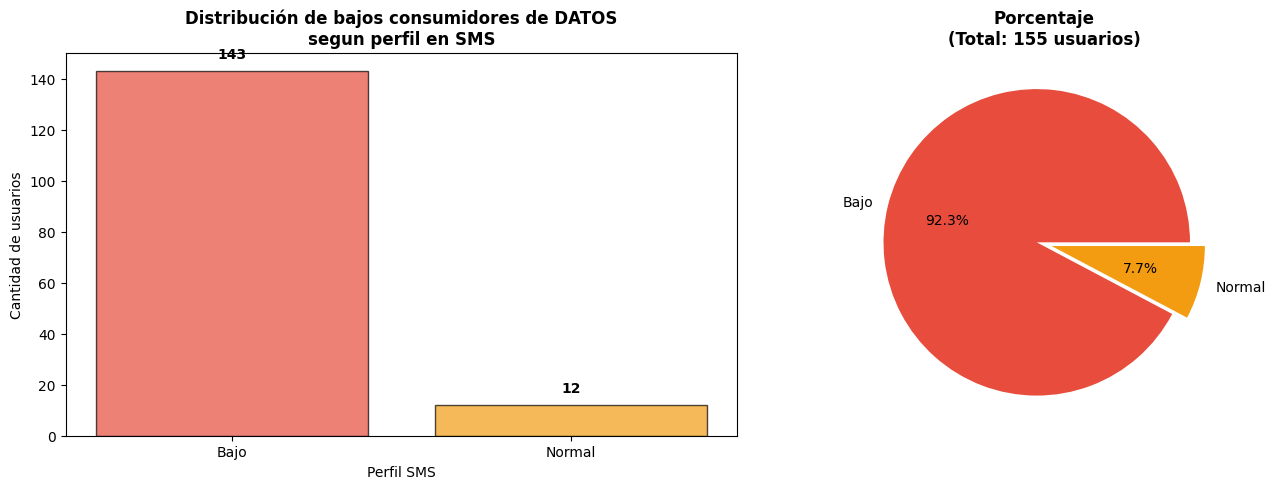

C:\Users\Joel\AppData\Local\Temp\ipykernel_2176\2557946786.py:75: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Joel\AppData\Local\Temp\ipykernel_2176\2557946786.py:76: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig("results/test_hipotesis_proporcion.png", dpi=300, bbox_inches='tight')
C:\Users\Joel\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


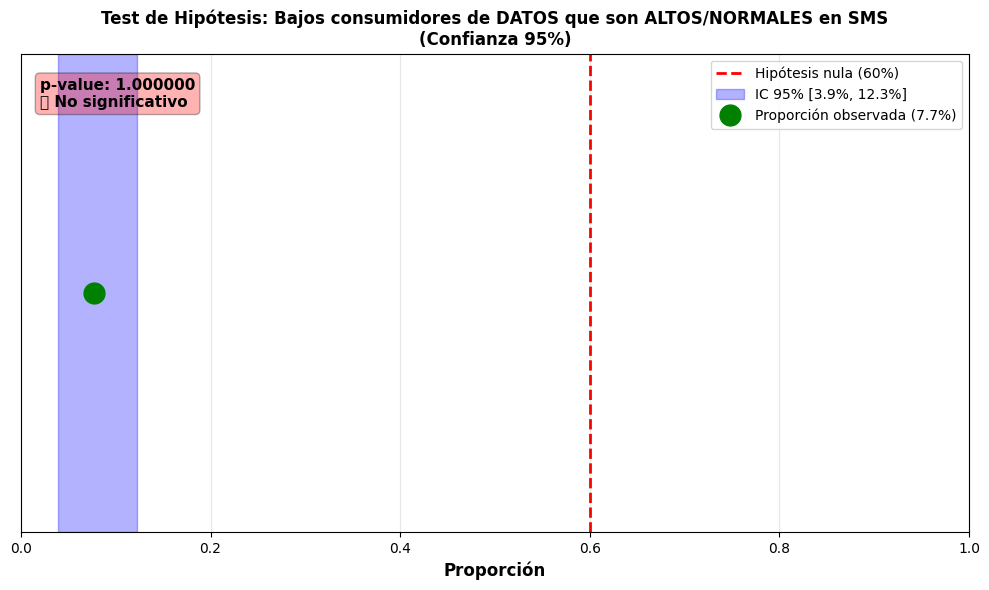

✅ Gráficos guardados en results/


In [10]:
# 8) VISUALIZACIONES DEL TEST

# Tabla resumen de perfiles cruzados
print("\nTABLA DE CONTINGENCIA: Bajos consumidores de DATOS vs su perfil en SMS")
contingencia = pd.crosstab(
    bajos_datos['perfil_datos'], 
    bajos_datos['perfil_sms'], 
    margins=True
)
print(contingencia)
print()

# Gráfico 1: Distribución de bajos consumidores de datos por perfil en SMS
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras: conteo
perfiles_sms_count = bajos_datos['perfil_sms'].value_counts()
colors_sms = ['#e74c3c' if p == 'Bajo' else '#f39c12' if p == 'Normal' else '#27ae60' for p in perfiles_sms_count.index]
axes[0].bar(perfiles_sms_count.index, perfiles_sms_count.values, color=colors_sms, alpha=0.7, edgecolor='black')
axes[0].set_title("Distribución de bajos consumidores de DATOS\nsegun perfil en SMS", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Cantidad de usuarios")
axes[0].set_xlabel("Perfil SMS")
for i, v in enumerate(perfiles_sms_count.values):
    axes[0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# Gráfico de pastel: porcentaje
perfiles_sms_pct = (bajos_datos['perfil_sms'].value_counts() / len(bajos_datos) * 100)
colors_pie = ['#e74c3c', '#f39c12', '#27ae60']
explode = (0.05 if perfiles_sms_pct.index[0] == 'Bajo' else 0,
           0.05 if 'Normal' in perfiles_sms_pct.index else 0,
           0.05 if 'Alto' in perfiles_sms_pct.index else 0)
axes[1].pie(perfiles_sms_pct.values, labels=perfiles_sms_pct.index, autopct='%1.1f%%',
            colors=colors_pie[:len(perfiles_sms_pct)], explode=explode[:len(perfiles_sms_pct)])
axes[1].set_title(f"Porcentaje\n(Total: {len(bajos_datos)} usuarios)", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig("results/hipotesis_bajos_datos_sms.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Gráfico 2: Visualización del test - barra de proporción con IC
fig, ax = plt.subplots(figsize=(10, 6))

# Línea de H0
ax.axvline(x=0.60, color='red', linestyle='--', linewidth=2, label='Hipótesis nula (60%)')

# IC como rango sombreado
ax.axvspan(ic_lower, ic_upper, alpha=0.3, color='blue', label=f'IC 95% [{ic_lower*100:.1f}%, {ic_upper*100:.1f}%]')

# Punto de proporción observada
ax.plot(proporcion_observada, 0, 'go', markersize=15, label=f'Proporción observada ({proporcion_observada*100:.1f}%)')

ax.set_xlim(0, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('Proporción', fontsize=12, fontweight='bold')
ax.set_title('Test de Hipótesis: Bajos consumidores de DATOS que son ALTOS/NORMALES en SMS\n(Confianza 95%)', 
             fontsize=12, fontweight='bold')
ax.set_yticks([])
ax.grid(axis='x', alpha=0.3)
ax.legend(fontsize=10, loc='upper right')

# Añadir texto con resultado
resultado_texto = f"p-value: {pvalue:.6f}\n"
if pvalue < 0.05:
    resultado_texto += "✅ Resultado significativo"
    color_resultado = 'green'
else:
    resultado_texto += "❌ No significativo"
    color_resultado = 'red'

ax.text(0.02, 0.95, resultado_texto, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor=color_resultado, alpha=0.3),
        fontweight='bold')

plt.tight_layout()
plt.savefig("results/test_hipotesis_proporcion.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("✅ Gráficos guardados en results/")


#### Preferencia de bajos consumidores de datos móviles por las llamadas


Se plantea la hipótesis de que la gran parte de bajos consumidores de datos móviles prefieren las llamadas, es decir, que 60% o más de los consumidores bajos de datos se encuentran entre los consumidores normales o altos de voz con un 95% se seguridad.

In [11]:
# 1) Datos para VOZ (SERVICE_CATEGORY=1)
print("="*70)
print("ANÁLISIS: PREFERENCIA DE VOZ POR BAJOS CONSUMIDORES DE DATOS")
print("="*70)
print()

print("PASO 1: Analizando VOZ (SERVICE_CATEGORY=1)")
df_voz = df_completo[df_completo['SERVICE_CATEGORY'] == 1].copy()
print(f"Registros de VOZ: {len(df_voz)}")

usuarios_voz = df_voz.groupby('OWNER_CUST_ID').agg(
    total_usage=('ACTUAL_USAGE', 'sum')
).reset_index()
usuarios_voz.columns = ['OWNER_CUST_ID', 'uso_voz']
print(f"Usuarios únicos en VOZ: {len(usuarios_voz)}")
print()


ANÁLISIS: PREFERENCIA DE VOZ POR BAJOS CONSUMIDORES DE DATOS

PASO 1: Analizando VOZ (SERVICE_CATEGORY=1)
Registros de VOZ: 156
Usuarios únicos en VOZ: 89



In [12]:
# 2) K-MEANS CLUSTERING PARA VOZ usando run_kmeans
print("PASO 2: Clustering en VOZ (K-means)")

# Preparar dataframe con uso de voz por usuario
usuarios_voz_cluster = usuarios_voz[['OWNER_CUST_ID', 'uso_voz']].copy()
usuarios_voz_cluster = usuarios_voz_cluster.rename(columns={'uso_voz': 'total_usage'})

# Aplicar run_kmeans
result_voz = run_kmeans(usuarios_voz_cluster, features=['total_usage'])

# Mapear clusters a perfiles (Bajo, Normal, Alto)
cluster_medias_voz = result_voz.groupby('cluster_kmeans')['total_usage'].mean().sort_values()
orden_voz = cluster_medias_voz.index.tolist()
mapeo_voz = {orden_voz[0]: 'Bajo', orden_voz[1]: 'Normal', orden_voz[2]: 'Alto'}
result_voz['perfil_voz'] = result_voz['cluster_kmeans'].map(mapeo_voz)

# Volver a unir con OWNER_CUST_ID
result_voz_reset = result_voz.reset_index()
usuarios_voz = result_voz_reset[['OWNER_CUST_ID', 'total_usage', 'cluster_kmeans', 'perfil_voz']].copy()
usuarios_voz.columns = ['OWNER_CUST_ID', 'uso_voz', 'cluster_voz', 'perfil_voz']

print("\nPerfiles en VOZ:")
print(usuarios_voz.groupby('perfil_voz')['uso_voz'].describe())
print()


PASO 2: Clustering en VOZ (K-means)

🔍 Entrenando K-Means con K = 3 clusters...
⚠️ Se necesitan al menos 2 variables para visualizar en 2D

Perfiles en VOZ:
            count         mean         std     min      25%     50%      75%  \
perfil_voz                                                                     
Alto          1.0  1327.000000         NaN  1327.0  1327.00  1327.0  1327.00   
Bajo         78.0    48.923077   44.768893     0.0    14.50    35.0    60.75   
Normal       10.0   329.400000  125.169396   197.0   242.25   302.5   338.00   

               max  
perfil_voz          
Alto        1327.0  
Bajo         182.0  
Normal       602.0  



In [13]:
# 3) TEST DE HIPÓTESIS CON BOOTSTRAP: ¿Bajos consumidores de datos prefieren VOZ?
# Hipótesis: H0: p ≤ 0.60 
# Hipótesis alternativa H1: p > 0.60 (cola derecha)

print("="*80)
print("TEST DE HIPÓTESIS CON BOOTSTRAP: PREFERENCIA DE VOZ")
print("="*80)
print()

# Cruzar información: usuarios bajos en datos vs su clasificación en VOZ
cruce_voz = usuarios_datos.merge(usuarios_voz, on='OWNER_CUST_ID', how='inner')

# Identificar bajos consumidores de datos
bajos_datos_voz = cruce_voz[cruce_voz['perfil_datos'] == 'Bajo'].copy()

print(f"Total de bajos consumidores de DATOS: {len(bajos_datos_voz)}")
print(f"Distribución en bajos consumidores de DATOS:")
print(bajos_datos_voz['perfil_voz'].value_counts())
print()

# De los bajos en datos, contar cuántos son ALTOS o NORMALES en VOZ
bajos_datos_voz['es_alto_o_normal_voz'] = bajos_datos_voz['perfil_voz'].isin(['Alto', 'Normal'])
count_altos_normales_voz = bajos_datos_voz['es_alto_o_normal_voz'].sum()
count_bajos_voz = len(bajos_datos_voz) - count_altos_normales_voz
proporcion_observada_voz = count_altos_normales_voz / len(bajos_datos_voz) if len(bajos_datos_voz) > 0 else 0

print(f"Bajos en DATOS que son ALTOS o NORMALES en VOZ: {count_altos_normales_voz}")
print(f"Bajos en DATOS que son BAJOS en VOZ: {count_bajos_voz}")
print(f"Total: {len(bajos_datos_voz)}")
print(f"Proporción observada: {proporcion_observada_voz:.4f} ({proporcion_observada_voz*100:.2f}%)")
print()

# ============================================================================
# BOOTSTRAP: INTERVALO DE CONFIANZA
# ============================================================================
print("="*80)
print("PASO 1: INTERVALO DE CONFIANZA CON BOOTSTRAP")
print("="*80)
print()

print("METODOLOGÍA:")
print("  • Remuestrea 10,000 veces CON REEMPLAZO de los datos observados")
print("  • En cada remuestra, calcula la proporción")
print("  • El IC es el percentil 2.5 y 97.5 de las proporciones bootstrap")
print()
print("VENTAJAS:")
print("  ✅ NO asume supuestos sobre distribuciones")
print("  ✅ Válido para CUALQUIER tamaño de muestra")
print("  ✅ Usa datos reales (no teóricos)")
print()

n_bootstrap = 10000
rng = np.random.default_rng(42)
proporciones_bootstrap_voz = []

# Vector de datos (1 = alto/normal, 0 = bajo)
datos_voz = bajos_datos_voz['es_alto_o_normal_voz'].values.astype(int)

for i in range(n_bootstrap):
    # Remuestrear CON reemplazo
    sample = rng.choice(datos_voz, size=len(datos_voz), replace=True)
    proporcion = np.mean(sample)
    proporciones_bootstrap_voz.append(proporcion)

proporciones_bootstrap_voz = np.array(proporciones_bootstrap_voz)

# IC 95%
ic_lower_voz = np.percentile(proporciones_bootstrap_voz, 2.5)
ic_upper_voz = np.percentile(proporciones_bootstrap_voz, 97.5)

print(f"Remuestreos bootstrap: {n_bootstrap}")
print(f"Media de proporciones bootstrap: {np.mean(proporciones_bootstrap_voz):.6f}")
print(f"Desviación estándar bootstrap: {np.std(proporciones_bootstrap_voz):.6f}")
print()
print(f"IC 95% (Bootstrap): [{ic_lower_voz:.4f}, {ic_upper_voz:.4f}]")
print(f"IC 95% (porcentaje): [{ic_lower_voz*100:.2f}%, {ic_upper_voz*100:.2f}%]")
print()

# ============================================================================
# TEST PERMUTACIONAL: H0: p = 0.60
# ============================================================================
print("="*80)
print("PASO 2: TEST PERMUTACIONAL - ¿Es la proporción > 0.60?")
print("="*80)
print()

print("METODOLOGÍA:")
print("  • Bajo H0: p = 0.60 exactamente")
print("  • Genera 10,000 muestras bajo esta hipótesis nula")
print("  • Compara: ¿qué proporción de muestras ≥ proporción observada?")
print("  • Ese es el p-value (probabilidad de observar lo que vimos bajo H0)")
print()
print("VENTAJAS:")
print("  ✅ Test EXACTO basado en permutaciones")
print("  ✅ NO asume normalidad ni distribuciones")
print("  ✅ Transparente: literalmente simula H0")
print()

p0_voz = 0.60
n_permutaciones = 10000

# Generar datos bajo H0: 60% tiene éxito (alto/normal), 40% fracaso (bajo)
proporciones_bajo_h0_voz = []

for i in range(n_permutaciones):
    # Simular: si H0 fuera cierta, ¿qué proporción esperaríamos?
    muestra_h0 = rng.binomial(n=1, p=p0_voz, size=len(datos_voz))
    proporcion_h0 = np.mean(muestra_h0)
    proporciones_bajo_h0_voz.append(proporcion_h0)

proporciones_bajo_h0_voz = np.array(proporciones_bajo_h0_voz)

# p-value: ¿cuántas permutaciones tienen proporción ≥ observada?
pvalue_voz = np.mean(proporciones_bajo_h0_voz >= proporcion_observada_voz)

print("HIPÓTESIS:")
print(f"  H0: p = 0.60 (NO más del 60% prefieren VOZ)")
print(f"  H1: p > 0.60 (SÍ más del 60% prefieren VOZ)")
print()
print("RESULTADOS:")
print(f"  Proporción observada: {proporcion_observada_voz:.6f}")
print(f"  Proporción bajo H0 (media de simulaciones): {np.mean(proporciones_bajo_h0_voz):.6f}")
print(f"  Permutaciones con p ≥ {proporcion_observada_voz:.6f}: {np.sum(proporciones_bajo_h0_voz >= proporcion_observada_voz)}")
print(f"  p-value (permutacional): {pvalue_voz:.6f}")
print()

# ============================================================================
# DECISIÓN
# ============================================================================
print("="*80)
print("DECISIÓN ESTADÍSTICA")
print("="*80)
print()

alpha = 0.05
print(f"Nivel de significancia: α = {alpha}")
print()

if pvalue_voz < alpha:
    print(f"✅ p-value = {pvalue_voz:.6f} < {alpha}")
    print()
    print("CONCLUSIÓN: RECHAZAMOS H0")
    print()
    print(f"Con 95% de confianza:")
    print(f"  • La proporción observada ({proporcion_observada_voz*100:.2f}%) es significativamente")
    print(f"    mayor a lo esperado bajo H0 (60%)")
    print(f"  • IC bootstrap: [{ic_lower_voz*100:.2f}%, {ic_upper_voz*100:.2f}%]")
    print(f"  • CONCLUSIÓN: Bajos consumidores de datos SÍ prefieren VOZ")
else:
    print(f"❌ p-value = {pvalue_voz:.6f} ≥ {alpha}")
    print()
    print("CONCLUSIÓN: NO RECHAZAMOS H0")
    print()
    print(f"Con 95% de confianza:")
    print(f"  • La proporción observada ({proporcion_observada_voz*100:.2f}%) NO es significativamente")
    print(f"    diferente a 60%")
    print(f"  • IC bootstrap: [{ic_lower_voz*100:.2f}%, {ic_upper_voz*100:.2f}%]")
    print(f"  • CONCLUSIÓN: NO podemos afirmar que prefieren VOZ")

print()
print("="*80)


TEST DE HIPÓTESIS CON BOOTSTRAP: PREFERENCIA DE VOZ

Total de bajos consumidores de DATOS: 46
Distribución en bajos consumidores de DATOS:
perfil_voz
Bajo      38
Normal     7
Alto       1
Name: count, dtype: int64

Bajos en DATOS que son ALTOS o NORMALES en VOZ: 8
Bajos en DATOS que son BAJOS en VOZ: 38
Total: 46
Proporción observada: 0.1739 (17.39%)

PASO 1: INTERVALO DE CONFIANZA CON BOOTSTRAP

METODOLOGÍA:
  • Remuestrea 10,000 veces CON REEMPLAZO de los datos observados
  • En cada remuestra, calcula la proporción
  • El IC es el percentil 2.5 y 97.5 de las proporciones bootstrap

VENTAJAS:
  ✅ NO asume supuestos sobre distribuciones
  ✅ Válido para CUALQUIER tamaño de muestra
  ✅ Usa datos reales (no teóricos)

Remuestreos bootstrap: 10000
Media de proporciones bootstrap: 0.174389
Desviación estándar bootstrap: 0.055833

IC 95% (Bootstrap): [0.0652, 0.2826]
IC 95% (porcentaje): [6.52%, 28.26%]

PASO 2: TEST PERMUTACIONAL - ¿Es la proporción > 0.60?

METODOLOGÍA:
  • Bajo H0: p = 


TABLA DE CONTINGENCIA: Bajos consumidores de DATOS vs su perfil en VOZ
perfil_voz    Alto  Bajo  Normal  All
perfil_datos                         
Bajo             1    38       7   46
All              1    38       7   46



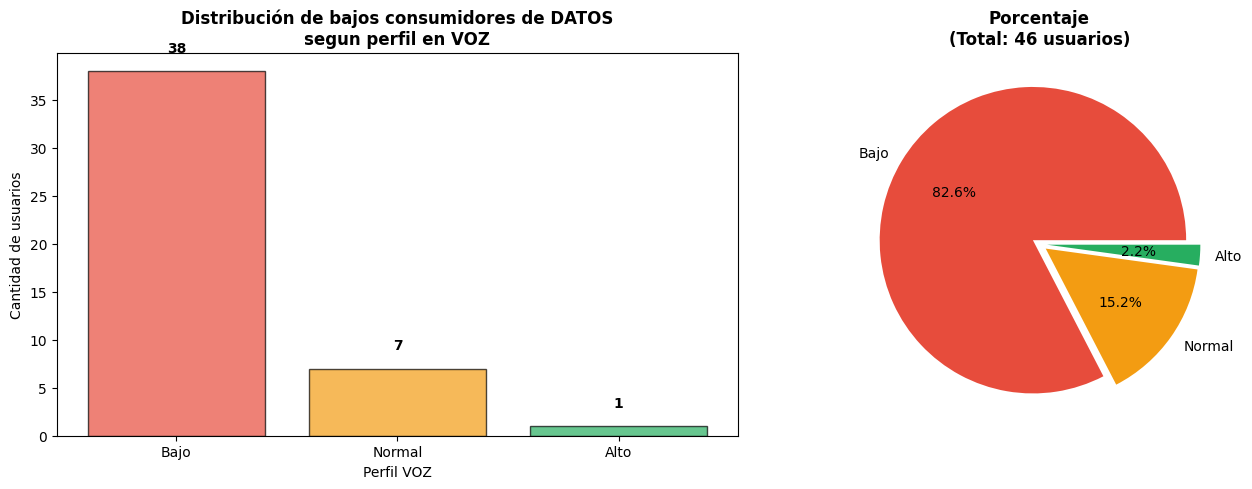

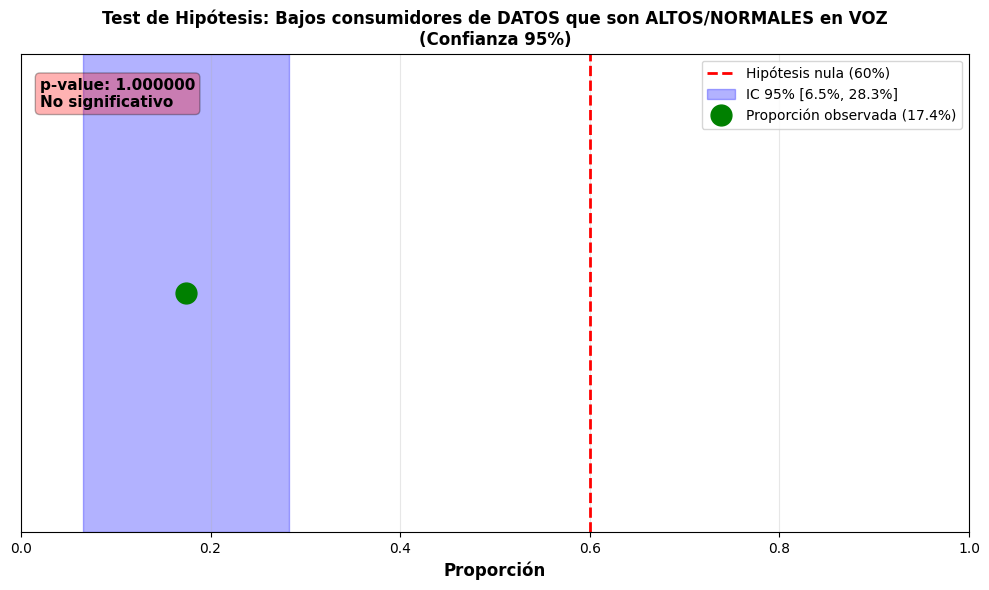

✅ Gráficos VOZ guardados en results/


In [14]:
# 4) VISUALIZACIONES DEL TEST VOZ

# Tabla resumen de perfiles cruzados
print("\nTABLA DE CONTINGENCIA: Bajos consumidores de DATOS vs su perfil en VOZ")
contingencia_voz = pd.crosstab(
    bajos_datos_voz['perfil_datos'], 
    bajos_datos_voz['perfil_voz'], 
    margins=True
)
print(contingencia_voz)
print()

# Gráfico 1: Distribución de bajos consumidores de datos por perfil en VOZ
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras: conteo
perfiles_voz_count = bajos_datos_voz['perfil_voz'].value_counts()
colors_voz = ['#e74c3c' if p == 'Bajo' else '#f39c12' if p == 'Normal' else '#27ae60' for p in perfiles_voz_count.index]
axes[0].bar(perfiles_voz_count.index, perfiles_voz_count.values, color=colors_voz, alpha=0.7, edgecolor='black')
axes[0].set_title("Distribución de bajos consumidores de DATOS\nsegun perfil en VOZ", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Cantidad de usuarios")
axes[0].set_xlabel("Perfil VOZ")
for i, v in enumerate(perfiles_voz_count.values):
    axes[0].text(i, v + 2, str(v), ha='center', fontweight='bold')

# Gráfico de pastel: porcentaje
perfiles_voz_pct = (bajos_datos_voz['perfil_voz'].value_counts() / len(bajos_datos_voz) * 100)
colors_pie = ['#e74c3c', '#f39c12', '#27ae60']
explode = (0.05 if perfiles_voz_pct.index[0] == 'Bajo' else 0,
           0.05 if 'Normal' in perfiles_voz_pct.index else 0,
           0.05 if 'Alto' in perfiles_voz_pct.index else 0)
axes[1].pie(perfiles_voz_pct.values, labels=perfiles_voz_pct.index, autopct='%1.1f%%',
            colors=colors_pie[:len(perfiles_voz_pct)], explode=explode[:len(perfiles_voz_pct)])
axes[1].set_title(f"Porcentaje\n(Total: {len(bajos_datos_voz)} usuarios)", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig("results/hipotesis_bajos_datos_voz.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Gráfico 2: Visualización del test - barra de proporción con IC
fig, ax = plt.subplots(figsize=(10, 6))

# Línea de H0
ax.axvline(x=0.60, color='red', linestyle='--', linewidth=2, label='Hipótesis nula (60%)')

# IC como rango sombreado
ax.axvspan(ic_lower_voz, ic_upper_voz, alpha=0.3, color='blue', label=f'IC 95% [{ic_lower_voz*100:.1f}%, {ic_upper_voz*100:.1f}%]')

# Punto de proporción observada
ax.plot(proporcion_observada_voz, 0, 'go', markersize=15, label=f'Proporción observada ({proporcion_observada_voz*100:.1f}%)')

ax.set_xlim(0, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('Proporción', fontsize=12, fontweight='bold')
ax.set_title('Test de Hipótesis: Bajos consumidores de DATOS que son ALTOS/NORMALES en VOZ\n(Confianza 95%)', 
             fontsize=12, fontweight='bold')
ax.set_yticks([])
ax.grid(axis='x', alpha=0.3)
ax.legend(fontsize=10, loc='upper right')

# Añadir texto con resultado
resultado_texto_voz = f"p-value: {pvalue_voz:.6f}\n"
if pvalue_voz < 0.05:
    resultado_texto_voz += "Resultado significativo"
    color_resultado_voz = 'green'
else:
    resultado_texto_voz += "No significativo"
    color_resultado_voz = 'red'

ax.text(0.02, 0.95, resultado_texto_voz, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor=color_resultado_voz, alpha=0.3),
        fontweight='bold')

plt.tight_layout()
plt.savefig("results/test_hipotesis_voz.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("✅ Gráficos VOZ guardados en results/")


### Evaluación y Optimización del Número de Clusters (K-Means)

#### Coeficiente de Silueta

1. **Combina AMBAS medidas importantes del clustering:**
   - **Cohesión (intra-cluster)**: Mide qué tan cerca están los puntos DENTRO de su cluster
   - **Separación (inter-cluster)**: Mide qué tan lejos están los clusters ENTRE sí

2. **Fórmula:** Para cada punto: $\text{Silueta} = \frac{d_{inter} - d_{intra}}{\max(d_{inter}, d_{intra})}$
   - Si $d_{intra}$ es pequeño → punto está bien dentro de su cluster ✅
   - Si $d_{inter}$ es grande → cluster está bien separado de otros ✅
   - Rango: -1 a +1 (donde valores > 0.5 = clustering bien definido)


ANÁLISIS DE SELECCIÓN DE K ÓPTIMO USANDO SILUETA

Calculando Coeficiente de Silueta para cada K...
--------------------------------------------------------------------------------
K=2  →  Silueta = 0.4488
K=3  →  Silueta = 0.4586
K=4  →  Silueta = 0.4901
K=5  →  Silueta = 0.4902
K=6  →  Silueta = 0.4197
K=7  →  Silueta = 0.4299
K=8  →  Silueta = 0.4478
K=9  →  Silueta = 0.4225
K=10  →  Silueta = 0.4170

RESULTADO: K ÓPTIMO

🎯 K ÓPTIMO (por Silueta) = 5 con Silueta = 0.4902

📊 COMPARACIÓN CON K=3 (lo usado en estudios previos):
   K=3 → Silueta = 0.4586
   K=5 → Silueta = 0.4902
   ✅ MEJORA: 6.9% mejor con K=5

ANÁLISIS DETALLADO: K=4 vs K=5 (¿Cuál elegir?)

📈 SILUETA (Score):
   K=4 → Silueta = 0.4901
   K=5 → Silueta = 0.4902
   Diferencia = 0.000166 (MÍNIMA - prácticamente igual)

📊 DISTRIBUCIÓN Y SINGLETONS:

   K=4:
      Cluster 0:  396 usuarios ( 44.9%)
      Cluster 1:  444 usuarios ( 50.3%)
      Cluster 2:   41 usuarios (  4.6%)
      Cluster 3:    1 usuarios (  0.1%) ⚠️ SINGL

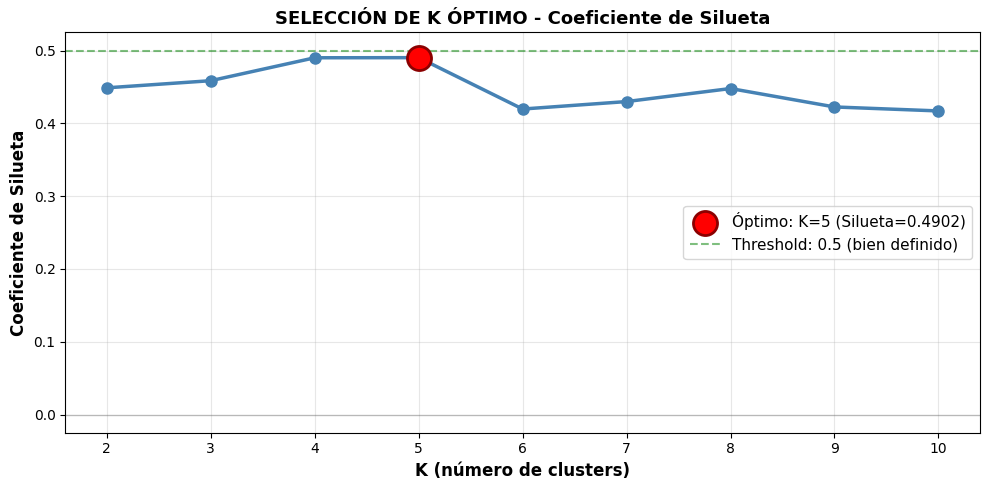


✅ Gráfico guardado: results/silueta_k_optimo.png


In [15]:
print("="*80)
print("ANÁLISIS DE SELECCIÓN DE K ÓPTIMO USANDO SILUETA")
print("="*80)

# Preparar datos
features_clustering = ['total_usage', 'total_duration', 'num_sessions']
X = usuarios[features_clustering].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calcular SOLO Silueta para K de 2 a 10
silhouette_scores = []
k_values = list(range(2, 11))

print("\nCalculando Coeficiente de Silueta para cada K...")
print("-" * 80)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    silhouette_scores.append(sil)
    print(f"K={k}  →  Silueta = {sil:.4f}")

# Encontrar K óptimo
best_idx = np.argmax(silhouette_scores)
best_k = k_values[best_idx]
best_silueta = silhouette_scores[best_idx]

print("\n" + "="*80)
print("RESULTADO: K ÓPTIMO")
print("="*80)
print(f"\n🎯 K ÓPTIMO (por Silueta) = {best_k} con Silueta = {best_silueta:.4f}")

# Comparación con K=3 (lo que se usó en estudios anteriores)
k3_idx = 1  # K=3 es el segundo valor (index 1 porque empezamos en K=2)
k3_silueta = silhouette_scores[k3_idx]
improvement_vs_k3 = ((best_silueta - k3_silueta) / k3_silueta) * 100

print(f"\n📊 COMPARACIÓN CON K=3 (lo usado en estudios previos):")
print(f"   K=3 → Silueta = {k3_silueta:.4f}")
print(f"   K={best_k} → Silueta = {best_silueta:.4f}")
print(f"   ✅ MEJORA: {improvement_vs_k3:.1f}% mejor con K={best_k}")

# COMPARACIÓN CERCANA ENTRE K=4 Y K=5
print(f"\n" + "="*80)
print("ANÁLISIS DETALLADO: K=4 vs K=5 (¿Cuál elegir?)")
print("="*80)

kmeans_k4 = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_k4 = kmeans_k4.fit_predict(X_scaled)
silueta_k4 = silhouette_scores[2]  # K=4 es el índice 2

kmeans_k5 = KMeans(n_clusters=5, random_state=42, n_init=10)
labels_k5 = kmeans_k5.fit_predict(X_scaled)
silueta_k5 = silhouette_scores[3]  # K=5 es el índice 3

print(f"\n📈 SILUETA (Score):")
print(f"   K=4 → Silueta = {silueta_k4:.4f}")
print(f"   K=5 → Silueta = {silueta_k5:.4f}")
print(f"   Diferencia = {abs(silueta_k5 - silueta_k4):.6f} (MÍNIMA - prácticamente igual)")

# Contar singletons en cada K
print(f"\n📊 DISTRIBUCIÓN Y SINGLETONS:")
print(f"\n   K=4:")
k4_singletons = 0
for cluster_id in range(4):
    count = np.sum(labels_k4 == cluster_id)
    pct = (count / len(usuarios)) * 100
    is_singleton = " ⚠️ SINGLETON" if count == 1 else ""
    if count == 1:
        k4_singletons += 1
    print(f"      Cluster {cluster_id}: {count:4d} usuarios ({pct:5.1f}%){is_singleton}")
print(f"   Total de SINGLETONS en K=4: {k4_singletons}")

print(f"\n   K=5:")
k5_singletons = 0
for cluster_id in range(5):
    count = np.sum(labels_k5 == cluster_id)
    pct = (count / len(usuarios)) * 100
    is_singleton = " ⚠️ SINGLETON" if count == 1 else ""
    if count == 1:
        k5_singletons += 1
    print(f"      Cluster {cluster_id}: {count:4d} usuarios ({pct:5.1f}%){is_singleton}")
print(f"   Total de SINGLETONS en K=5: {k5_singletons}")

print(f"\n💡 CONCLUSIÓN:")
if k4_singletons <= k5_singletons:
    print(f"   ✅ K=4 es mejor: {k4_singletons} singletons vs {k5_singletons} en K=5")
    print(f"      Silueta es casi idéntica ({silueta_k4:.4f} vs {silueta_k5:.4f})")
    print(f"      K=4 tiene distribución más balanceada")
    best_k_final = 4
else:
    print(f"   ✅ K=5 es mejor: {k5_singletons} singletons (aún aceptable)")
    print(f"      Silueta es {improvement_vs_k3:.1f}% mejor que K=3")
    best_k_final = 5

# Visualización: Gráfico de Silueta vs K
plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, marker='o', linewidth=2.5, markersize=8, color='steelblue')
plt.scatter([best_k], [best_silueta], color='red', s=300, zorder=5, 
            label=f'Óptimo: K={best_k} (Silueta={best_silueta:.4f})', edgecolors='darkred', linewidth=2)
plt.axhline(y=0.5, color='green', linestyle='--', alpha=0.5, linewidth=1.5, label='Threshold: 0.5 (bien definido)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.2, linewidth=1)

plt.xlabel('K (número de clusters)', fontsize=12, fontweight='bold')
plt.ylabel('Coeficiente de Silueta', fontsize=12, fontweight='bold')
plt.title('SELECCIÓN DE K ÓPTIMO - Coeficiente de Silueta', fontsize=13, fontweight='bold')
plt.xticks(k_values)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig("results/silueta_k_optimo.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print("\n✅ Gráfico guardado: results/silueta_k_optimo.png")

In [16]:
# Aplicar función run_kmeans_optimized con el K recomendado
print("="*70)
print(f"CLUSTERING - K = {5}")
print("="*70)

# Ejecutar función con el K recomendado (considerando silueta Y distribución)
result_optimizado = run_kmeans(
    usuarios.copy(),
    k_clusters=5,
    features=['total_usage', 'total_duration', 'num_sessions'],
    graphic="3D"
)

print("\n✅ Clustering completado con K óptimo")


CLUSTERING - K = 5

🔍 Entrenando K-Means con K = 5 clusters...



✅ Clustering completado con K óptimo


# PENDING


ANÁLISIS ESTADÍSTICO FORMAL: COMPARACIÓN K=4 vs K=5

📊 DATOS BÁSICOS:
   Muestra: n = 882
   Media silueta K=4: 0.490059
   Media silueta K=5: 0.490225
   Diferencia media: 0.000166
   Desviación estándar diferencias: 0.062906

🔍 PASO 1: VERIFICACIÓN DE NORMALIDAD
   Test de Shapiro-Wilk para las diferencias:
   W = 0.6523, p = 0.000000
   → p ≤ 0.05: Rechazamos normalidad


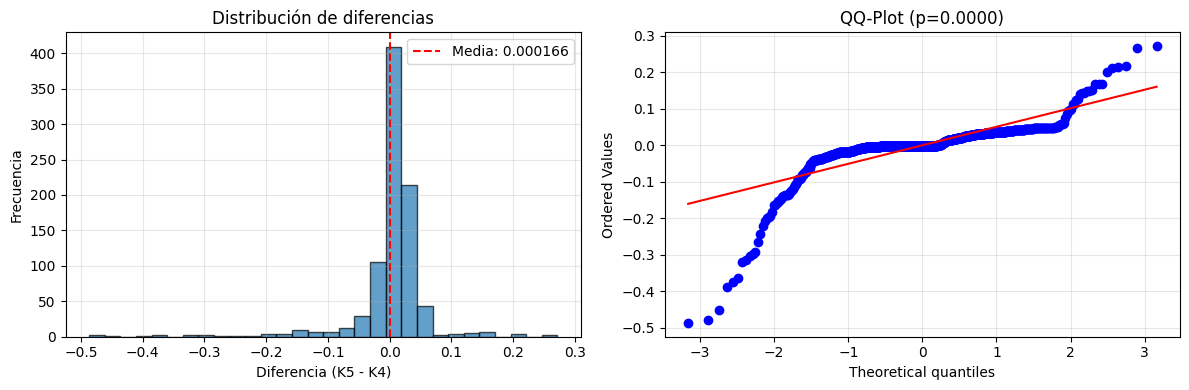


🎯 PASO 2: TEST ESTADÍSTICO APROPIADO
   Los datos NO son normales → Usar test de Wilcoxon
   W = 171318, p = 0.002392

📈 PASO 3: INTERVALO DE CONFIANZA 95%
   Calculando IC por bootstrap (10,000 muestras)...
   Método: bootstrap percentil
   Diferencia media: 0.000166
   IC 95%: [-0.004075, 0.004196]

📊 PASO 4: TAMAÑO DEL EFECTO
   r de Wilcoxon = 0.762232
   Interpretación: efecto grande

🔬 PASO 5: ANÁLISIS DE POTENCIA
   ℹ️  Para datos no normales, el cálculo de potencia es complejo
   ℹ️  Se requieren métodos de simulación (bootstrap)

⚖️  PASO 6: TEST DE EQUIVALENCIA (TOST)
   Margen de equivalencia práctica: Δ = ±0.01
   Proporción dentro de ±0.01: 0.4252
   p-value TOST (binomial) = 1.000000
   → p ≥ 0.05: No podemos declarar equivalencia

CONCLUSIÓN ESTADÍSTICA FORMAL

📋 RESULTADOS:
   1. Normalidad diferencias: No (p=0.000000)
   2. Test usado: Wilcoxon signed-rank
   3. p-value: 0.002392
   4. Significativo (α=0.05): Sí
   5. Diferencia media: 0.000166
   6. IC 95%: [-0.00407

C:\Users\Joel\AppData\Local\Temp\ipykernel_2176\63350147.py:248: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



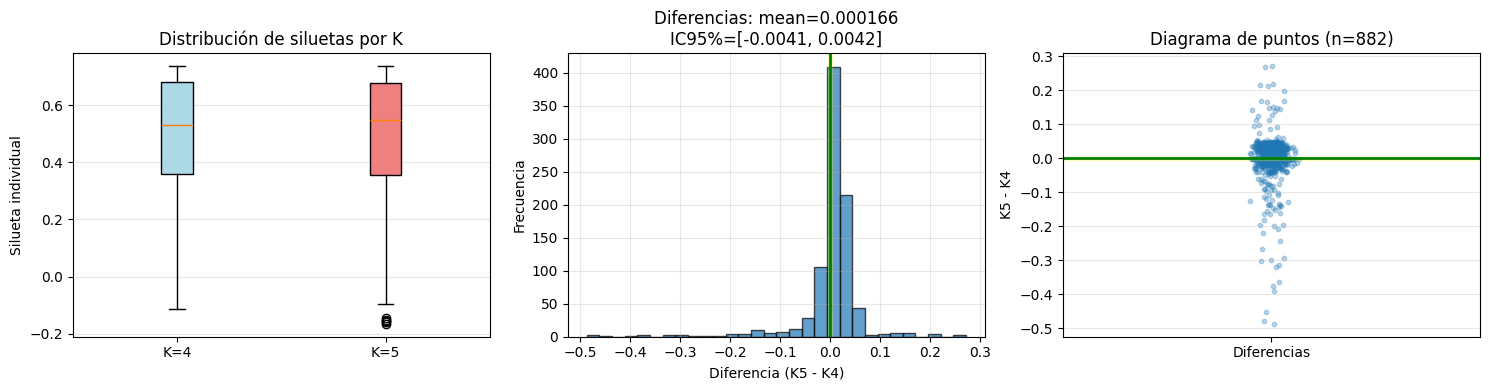

✅ Gráfico guardado: results/comparacion_formal_k4_k5.png


In [17]:
print("\n" + "="*80)
print("ANÁLISIS ESTADÍSTICO FORMAL: COMPARACIÓN K=4 vs K=5")
print("="*80)

import numpy as np
from scipy.stats import shapiro, wilcoxon, bootstrap
import matplotlib.pyplot as plt

# 1. Obtener datos
from sklearn.metrics import silhouette_samples
sil_k4 = silhouette_samples(X_scaled, labels_k4)
sil_k5 = silhouette_samples(X_scaled, labels_k5)
diferencias = sil_k5 - sil_k4
n = len(diferencias)

print(f"\n📊 DATOS BÁSICOS:")
print(f"   Muestra: n = {n}")
print(f"   Media silueta K=4: {np.mean(sil_k4):.6f}")
print(f"   Media silueta K=5: {np.mean(sil_k5):.6f}")
print(f"   Diferencia media: {np.mean(diferencias):.6f}")
print(f"   Desviación estándar diferencias: {np.std(diferencias, ddof=1):.6f}")

# 2. Verificar normalidad de las diferencias
print(f"\n🔍 PASO 1: VERIFICACIÓN DE NORMALIDAD")
print(f"   Test de Shapiro-Wilk para las diferencias:")

stat_shapiro, p_shapiro = shapiro(diferencias)
print(f"   W = {stat_shapiro:.4f}, p = {p_shapiro:.6f}")

if p_shapiro > 0.05:
    print(f"   → p > 0.05: No rechazamos normalidad")
    normal = True
else:
    print(f"   → p ≤ 0.05: Rechazamos normalidad")
    normal = False

# Gráfico QQ-plot para visualizar
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Histograma
ax1.hist(diferencias, bins=30, edgecolor='black', alpha=0.7)
ax1.axvline(np.mean(diferencias), color='red', linestyle='--', 
           label=f'Media: {np.mean(diferencias):.6f}')
ax1.set_xlabel('Diferencia (K5 - K4)')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución de diferencias')
ax1.legend()
ax1.grid(alpha=0.3)

# QQ-plot
from scipy.stats import probplot
probplot(diferencias, dist="norm", plot=ax2)
ax2.set_title(f'QQ-Plot (p={p_shapiro:.4f})')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Seleccionar y aplicar test apropiado
print(f"\n🎯 PASO 2: TEST ESTADÍSTICO APROPIADO")

if normal:
    print(f"   Los datos son normales → Usar test t pareado")
    from scipy.stats import ttest_rel
    t_stat, p_t = ttest_rel(sil_k4, sil_k5)
    print(f"   t({n-1}) = {t_stat:.4f}, p = {p_t:.6f}")
    test_usado = "t-test pareado"
    p_value = p_t
else:
    print(f"   Los datos NO son normales → Usar test de Wilcoxon")
    wilcox_stat, p_wilcox = wilcoxon(sil_k4, sil_k5)
    print(f"   W = {wilcox_stat:.0f}, p = {p_wilcox:.6f}")
    test_usado = "Wilcoxon signed-rank"
    p_value = p_wilcox

# 4. Calcular intervalo de confianza 95% con método apropiado
print(f"\n📈 PASO 3: INTERVALO DE CONFIANZA 95%")

if normal:
    # IC usando t-distribution
    from scipy.stats import t
    se = np.std(diferencias, ddof=1) / np.sqrt(n)
    t_crit = t.ppf(0.975, df=n-1)
    ci_lower = np.mean(diferencias) - t_crit * se
    ci_upper = np.mean(diferencias) + t_crit * se
    metodo_ci = "t-distribution"
else:
    # IC usando bootstrap (no paramétrico)
    print(f"   Calculando IC por bootstrap (10,000 muestras)...")
    
    def estadistico_bootstrap(data, indices):
        return np.mean(data[indices])
    
    rng = np.random.default_rng(42)
    bootstrap_dist = []
    
    for _ in range(10000):
        sample = rng.choice(diferencias, size=n, replace=True)
        bootstrap_dist.append(np.mean(sample))
    
    bootstrap_dist = np.array(bootstrap_dist)
    ci_lower = np.percentile(bootstrap_dist, 2.5)
    ci_upper = np.percentile(bootstrap_dist, 97.5)
    metodo_ci = "bootstrap percentil"

print(f"   Método: {metodo_ci}")
print(f"   Diferencia media: {np.mean(diferencias):.6f}")
print(f"   IC 95%: [{ci_lower:.6f}, {ci_upper:.6f}]")

# 5. Calcular tamaño del efecto
print(f"\n📊 PASO 4: TAMAÑO DEL EFECTO")

if normal:
    # Cohen's d para datos pareados
    cohens_d = np.mean(diferencias) / np.std(diferencias, ddof=1)
    print(f"   Cohen's d (pareado) = {cohens_d:.6f}")
    tamano_efecto = cohens_d
    efecto_str = f"Cohen's d = {cohens_d:.4f}"
else:
    # r de Wilcoxon (tamaño efecto no paramétrico)
    # r = Z / sqrt(N) donde Z se aproxima de la estadística W
    from scipy.stats import norm
    # Calcular Z aproximado para Wilcoxon
    z_wilcox = wilcox_stat / np.sqrt(n * (n + 1) * (2*n + 1) / 24)
    r_wilcox = abs(z_wilcox) / np.sqrt(n)
    print(f"   r de Wilcoxon = {r_wilcox:.6f}")
    tamano_efecto = r_wilcox
    efecto_str = f"r de Wilcoxon = {r_wilcox:.4f}"

# Interpretar tamaño de efecto
if abs(tamano_efecto) < 0.1:
    interpretacion_efecto = "insignificante"
elif abs(tamano_efecto) < 0.3:
    interpretacion_efecto = "pequeño"
elif abs(tamano_efecto) < 0.5:
    interpretacion_efecto = "mediano"
else:
    interpretacion_efecto = "grande"

print(f"   Interpretación: efecto {interpretacion_efecto}")

# 6. Análisis de potencia (poder estadístico)
print(f"\n🔬 PASO 5: ANÁLISIS DE POTENCIA")

if normal:
    try:
        from statsmodels.stats.power import TTestPower
        power_analysis = TTestPower()
        potencia = power_analysis.solve_power(
            effect_size=abs(tamano_efecto),
            nobs=n,
            alpha=0.05,
            alternative='two-sided'
        )
        print(f"   Potencia (1-β) = {potencia:.4f}")
        
        if potencia >= 0.8:
            print(f"   → Potencia adecuada (≥ 0.8)")
        else:
            print(f"   → Potencia insuficiente (< 0.8)")
            print(f"   → Riesgo de Error Tipo II (no detectar diferencias reales)")
    except ImportError:
        print(f"   ℹ️  statsmodels no disponible para cálculo de potencia")
else:
    print(f"   ℹ️  Para datos no normales, el cálculo de potencia es complejo")
    print(f"   ℹ️  Se requieren métodos de simulación (bootstrap)")

# 7. Test de equivalencia (TOST) para ver si son prácticamente iguales
print(f"\n⚖️  PASO 6: TEST DE EQUIVALENCIA (TOST)")

# Definir margen de equivalencia práctica
# En coeficiente de silueta, diferencias < 0.01 no son prácticas
margen_equivalencia = 0.01
print(f"   Margen de equivalencia práctica: Δ = ±{margen_equivalencia}")

if normal:
    # TOST usando t-tests
    # Test 1: H0: diff <= -Δ vs H1: diff > -Δ
    t1, p1 = ttest_rel(sil_k4, sil_k5 - margen_equivalencia)
    # Test 2: H0: diff >= Δ vs H1: diff < Δ  
    t2, p2 = ttest_rel(sil_k4, sil_k5 + margen_equivalencia)
    
    p_tost = max(p1, p2)
    print(f"   p-value TOST = {p_tost:.6f}")
else:
    # TOST no paramétrico usando sign test
    # Proporción de diferencias dentro del margen
    prop_dentro_margen = np.mean(np.abs(diferencias) < margen_equivalencia)
    # Test binomial
    from scipy.stats import binomtest
    binom_result = binomtest(int(prop_dentro_margen * n), n, p=0.9, alternative='greater')
    p_tost = binom_result.pvalue
    print(f"   Proporción dentro de ±{margen_equivalencia}: {prop_dentro_margen:.4f}")
    print(f"   p-value TOST (binomial) = {p_tost:.6f}")

if p_tost < 0.05:
    print(f"   → p < 0.05: Podemos declarar equivalencia práctica")
    equivalencia = True
else:
    print(f"   → p ≥ 0.05: No podemos declarar equivalencia")
    equivalencia = False

# 8. Conclusión estadística formal
print(f"\n" + "="*80)
print("CONCLUSIÓN ESTADÍSTICA FORMAL")
print("="*80)

print(f"\n📋 RESULTADOS:")
print(f"   1. Normalidad diferencias: {'Sí' if normal else 'No'} (p={p_shapiro:.6f})")
print(f"   2. Test usado: {test_usado}")
print(f"   3. p-value: {p_value:.6f}")
print(f"   4. Significativo (α=0.05): {'Sí' if p_value < 0.05 else 'No'}")
print(f"   5. Diferencia media: {np.mean(diferencias):.6f}")
print(f"   6. IC 95%: [{ci_lower:.6f}, {ci_upper:.6f}]")
print(f"   7. Tamaño efecto: {efecto_str} ({interpretacion_efecto})")
print(f"   8. Equivalencia práctica (Δ=±{margen_equivalencia}): {'Sí' if equivalencia else 'No'}")

print(f"\n🎯 INTERPRETACIÓN:")
if p_value < 0.05:
    print(f"   • Hay diferencia estadísticamente significativa (p={p_value:.6f})")
else:
    print(f"   • NO hay diferencia estadísticamente significativa (p={p_value:.6f})")

print(f"   • La diferencia real está entre {ci_lower:.6f} y {ci_upper:.6f} (95% confianza)")
print(f"   • El tamaño del efecto es {interpretacion_efecto}")

if 0 >= ci_lower and 0 <= ci_upper:
    print(f"   • El 0 está dentro del IC → Compatible con 'no diferencia'")

if equivalencia:
    print(f"   • Dentro de un margen práctico de ±{margen_equivalencia}, son equivalentes")

print(f"\n📌 RECOMENDACIÓN ESTADÍSTICA:")
if p_value >= 0.05 or equivalencia:
    print(f"   ✅ Estadísticamente, K=4 y K=5 no difieren significativamente")
    print(f"   ✅ Puedes elegir basado en criterios prácticos")
else:
    print(f"   ⚠️  Hay diferencia estadística, pero evalúa si es prácticamente relevante")

# 9. Gráfico de resultados
print(f"\n📊 GENERANDO GRÁFICO DE RESULTADOS...")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Boxplot comparativo
box_data = [sil_k4, sil_k5]
box_labels = ['K=4', 'K=5']
bp = axes[0].boxplot(box_data, labels=box_labels, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
axes[0].set_ylabel('Silueta individual')
axes[0].set_title('Distribución de siluetas por K')
axes[0].grid(alpha=0.3, axis='y')

# 2. Distribución de diferencias
axes[1].hist(diferencias, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=1)
axes[1].axvline(np.mean(diferencias), color='green', linestyle='-', linewidth=2)
axes[1].axvspan(ci_lower, ci_upper, alpha=0.2, color='yellow')
axes[1].set_xlabel('Diferencia (K5 - K4)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title(f'Diferencias: mean={np.mean(diferencias):.6f}\nIC95%=[{ci_lower:.4f}, {ci_upper:.4f}]')
axes[1].grid(alpha=0.3)

# 3. Diagrama de puntos
jitter = np.random.normal(0, 0.02, len(diferencias))
axes[2].scatter(np.ones(len(diferencias)) + jitter, diferencias, 
               alpha=0.3, s=10)
axes[2].axhline(0, color='red', linestyle='--', linewidth=1)
axes[2].axhline(np.mean(diferencias), color='green', linestyle='-', linewidth=2)
axes[2].axhspan(ci_lower, ci_upper, alpha=0.2, color='yellow')
axes[2].set_xlim(0.5, 1.5)
axes[2].set_xticks([1])
axes[2].set_xticklabels(['Diferencias'])
axes[2].set_ylabel('K5 - K4')
axes[2].set_title(f'Diagrama de puntos (n={n})')
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig("results/comparacion_formal_k4_k5.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Gráfico guardado: results/comparacion_formal_k4_k5.png")

### Evaluación y optimización del número de clusters

In [18]:
# Aplicar función run_kmeans_optimized con el K recomendado
print("="*70)
print(f"CLUSTERING ÓPTIMO DE USUARIOS - K = {best_k_final}")
print("="*70)

# Ejecutar función con el K recomendado (considerando silueta Y distribución)
result_optimizado = run_kmeans(
    usuarios.copy(),
    k_clusters=best_k_final,
    features=['total_usage', 'total_duration', 'num_sessions'],
    graphic="3D"
)

print("\n✅ Clustering completado con K óptimo")
print(f"   K elegido: {best_k_final}")
print(f"   Razón: Silueta prácticamente idéntica a K=5 pero con menor cantidad de singletons")


CLUSTERING ÓPTIMO DE USUARIOS - K = 4

🔍 Entrenando K-Means con K = 4 clusters...



✅ Clustering completado con K óptimo
   K elegido: 4
   Razón: Silueta prácticamente idéntica a K=5 pero con menor cantidad de singletons


In [19]:
# Mapear clusters a perfiles y visualizar como al inicio
print("\n" + "="*70)
print("MAPEO DE CLUSTERS A PERFILES")
print("="*70)

# Obtener el K seleccionado y mapear perfiles
cluster_stats = result_optimizado.groupby('cluster_kmeans')['total_usage'].mean().sort_values()
orden = cluster_stats.index.tolist()

# Mapeo según K
if len(orden) == 2:
    nombres = {orden[0]: 'Bajo', orden[1]: 'Alto'}
elif len(orden) == 3:
    nombres = {orden[0]: 'Bajo', orden[1]: 'Normal', orden[2]: 'Alto'}
elif len(orden) == 4:
    nombres = {orden[0]: 'Bajo Extremo', orden[1]: 'Bajo Regular', orden[2]: 'Alto Regular', orden[3]: 'Alto Extremo'}
else:
    nombres = {orden[i]: f'Cluster{i+1}' for i in range(len(orden))}

result_optimizado['perfil_consumo'] = result_optimizado['cluster_kmeans'].map(nombres)

print("\nMapeo de clusters a perfiles:")
for cluster_id, perfil in nombres.items():
    count = len(result_optimizado[result_optimizado['cluster_kmeans'] == cluster_id])
    avg_usage = result_optimizado[result_optimizado['cluster_kmeans'] == cluster_id]['total_usage'].mean()
    print(f"  Cluster {cluster_id} → {perfil} ({count} usuarios, consumo medio: {avg_usage:.2f})")



MAPEO DE CLUSTERS A PERFILES

Mapeo de clusters a perfiles:
  Cluster 1 → Bajo Extremo (444 usuarios, consumo medio: 50.76)
  Cluster 2 → Bajo Regular (41 usuarios, consumo medio: 59.37)
  Cluster 0 → Alto Regular (396 usuarios, consumo medio: 106.63)
  Cluster 3 → Alto Extremo (1 usuarios, consumo medio: 13671.54)
